In [52]:
import pdb
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

import Distributions.nhanes as nhanes

%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
DATA_PATH = '/Users/kimmo/Documents/projects/OpportunisticLearning/Distributions/run_data/CDC/NHANES/'


columns = [
        # Gender
        nhanes.FeatureColumn('Demographics', 'RIAGENDR', 
                              None, None),
        # Age at time of screening
        nhanes.FeatureColumn('Demographics', 'RIDAGEYR', 
                             nhanes.preproc_cut, [0,12,30,60,81]),
        # Alcohol consumption
        nhanes.FeatureColumn('Questionnaire', 'ALQ120U', 
                             nhanes.preproc_lim, 3),
        nhanes.FeatureColumn('Questionnaire', 'ALQ120Q', 
                             nhanes.preproc_lim, 365),
        # Smoking
        nhanes.FeatureColumn('Questionnaire', 'SMQ020', 
                             nhanes.preproc_lim, 2),
    
        # Blood pressure
        nhanes.FeatureColumn('Examination', 'BPXDI1', 
                             nhanes.preproc_cut, [0,80,90,1000]),
        # LDL-cholesterol
        nhanes.FeatureColumn('Laboratory', 'LBDLDL', 
                             nhanes.preproc_cut, [0,100,376]),
        # BMI
        nhanes.FeatureColumn('Examination', 'BMXBMI', 
                             nhanes.preproc_cut, [0,25,30,1000]),

        # TARGET: Fasting Glucose
        nhanes.FeatureColumn('Laboratory', 'LBXGLU', 
                             nhanes.preproc_cut, [0,120,1000]),
        # TARGET: Heart
        nhanes.FeatureColumn('Questionnaire', 'MCQ160B', 
                             None, None),
        nhanes.FeatureColumn('Questionnaire', 'MCQ160C', 
                             None, None),
        nhanes.FeatureColumn('Questionnaire', 'MCQ160E', 
                             None, None),
        nhanes.FeatureColumn('Questionnaire', 'MCQ160F', 
                             None, None),
    ]

dataset = nhanes.NHANES(DATA_PATH, columns)
df = dataset.process()

len(columns)

df.loc[pd.isna(df['ALQ120U']), 'ALQ120Q'] = np.nan
df.loc[df['ALQ120U']==1, 'ALQ120Q'] = df['ALQ120Q']/7
df.loc[df['ALQ120U']==2, 'ALQ120Q'] = df['ALQ120Q']/30
df.loc[df['ALQ120U']==3, 'ALQ120Q'] = df['ALQ120Q']/365
df = df.drop(['ALQ120U'], axis=1)
df['ALQ120Q'] = pd.cut(df['ALQ120Q'], [0,0.2,1.0], labels=False)

(df[['MCQ160E','MCQ160F']] - 1)#.any(1, skipna=False)
df_tmp = df.loc[~df['MCQ160E'].isna(), ['MCQ160B', 'MCQ160C', 'MCQ160E', 'MCQ160F']]-1
df['HEARTDISEASE'] = ~df_tmp.all(axis=1)
df = df.drop( ['MCQ160B', 'MCQ160C', 'MCQ160E', 'MCQ160F'], axis=1)

Processing: VIQ.XPT

In [55]:
df.RIAGENDR = pd.Categorical(df.RIAGENDR)
df.RIAGENDR = df.RIAGENDR.cat.rename_categories({1.0: "Female", 2.0: "Male"})

df.RIDAGEYR = pd.Categorical(df.RIDAGEYR)
df.RIDAGEYR = df.RIDAGEYR.cat.rename_categories({0.0: "age0_12", 1.0: "age13_30", 2.0: "age31_60", 3.0: "age61_81"})

df.ALQ120Q = pd.Categorical(df.ALQ120Q)
df.ALQ120Q = df.ALQ120Q.cat.rename_categories({0.0: "Low", 1.0: "High"})

df.SMQ020 = pd.Categorical(df.SMQ020)
df.SMQ020 = df.SMQ020.cat.rename_categories({1.0:"Low", 2.0:"High"})

df.BPXDI1 = pd.Categorical(df.BPXDI1)
df.BPXDI1 = df.BPXDI1.cat.rename_categories({0.0: "Under_80", 1.0: "at_80_90", 2.0: "Over_90"})

df.LBDLDL = pd.Categorical(df.LBDLDL)
df.LBDLDL = df.LBDLDL.cat.rename_categories({0.0: "Under_100", 1.0: "Over_100"})

df.BMXBMI = pd.Categorical(df.BMXBMI)
df.BMXBMI = df.BMXBMI.cat.rename_categories({0.0: "Normal", 1.0: "Overweight", 2.0: "Obese"})

df.LBXGLU = pd.Categorical(df.LBXGLU)
df.LBXGLU = df.LBXGLU.cat.rename_categories({0.0: "Normal", 1.0: "High"})

df.HEARTDISEASE = pd.Categorical(df.HEARTDISEASE)
df.HEARTDISEASE = df.HEARTDISEASE.cat.rename_categories({False: "No", True: "Yes"})

In [56]:
df.columns = ["gender", "age", "alcohol", "smoke", "blood_pressure", "ldl", "bmi", "glucose", "heart_d"]

In [57]:
df.to_csv("evidence.csv", na_rep="N/A", index=False)

In [106]:
df.to_pickle('./data.pkl')

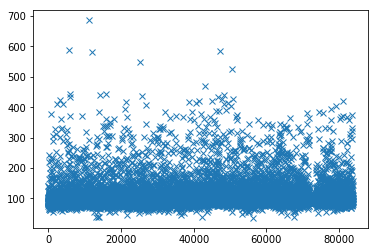

In [4]:
#df.set_index('SEQN', inplace=True)
plt.figure()
plt.plot(df['LBXGLU'], ' ', marker='x')

In [5]:
pd.isna(df).mean()

RIAGENDR        0.000000
RIDAGEYR        0.000000
RIDRETH3#1.0    0.000000
RIDRETH3#2.0    0.000000
RIDRETH3#3.0    0.000000
RIDRETH3#4.0    0.000000
RIDRETH3#6.0    0.000000
RIDRETH3#7.0    0.000000
RIDRETH1#1.0    0.000000
RIDRETH1#2.0    0.000000
RIDRETH1#3.0    0.000000
RIDRETH1#4.0    0.000000
RIDRETH1#5.0    0.000000
INDHHINC        0.000000
DMDEDUC2        0.000000
BPXSY1          0.000000
BPXDI1          0.000000
BPXSY2          0.000000
BPXDI2          0.000000
BPXSY3          0.000000
BPXDI3          0.000000
BPXSY4          0.000000
BPXDI4          0.000000
BMXBMI          0.000000
BMXWAIST        0.000000
BMXHT           0.000000
BMXLEG          0.000000
BMXWT           0.000000
LBXTC           0.000000
LBXTR           0.000000
LBXGLU          0.723295
LBXFB           0.000000
LBDLDL          0.000000
ALQ101          0.000000
ALQ120Q         0.000000
PAQ605          0.000000
PAQ620          0.000000
PAQ180          0.000000
SLD010H         0.000000
SMQ020#1.0      0.000000


In [6]:
df.describe()

,RIAGENDR,RIDAGEYR,RIDRETH3#1.0,RIDRETH3#2.0,RIDRETH3#3.0,RIDRETH3#4.0,RIDRETH3#6.0,RIDRETH3#7.0,RIDRETH1#1.0,RIDRETH1#2.0,...,PAQ620,PAQ180,SLD010H,SMQ020#1.0,SMQ020#2.0,SMQ020#7.0,SMQ020#9.0,SMD030,MCQ250A,BPQ020
count,9.206200e+04,9.206200e+04,92062.000000,92062.000000,92062.000000,92062.000000,92062.000000,92062.000000,92062.000000,92062.000000,...,9.206200e+04,9.206200e+04,9.206200e+04,92062.000000,92062.000000,92062.000000,92062.000000,9.206200e+04,9.206200e+04,9.206200e+04
mean,-1.389256e-17,-1.636235e-17,0.054376,0.036323,0.105505,0.076894,0.036910,0.014794,0.228998,0.081184,...,1.612772e-15,2.006113e-15,1.197721e-15,0.247420,0.296365,0.000196,0.000434,1.034533e-15,-5.618769e-17,-9.585867e-17
std,1.000000e+00,1.000000e+00,0.226760,0.187094,0.307205,0.266424,0.188542,0.120730,0.420190,0.273120,...,1.000000e+00,1.000000e+00,1.000000e+00,0.431515,0.456657,0.013982,0.020840,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.015209e+00,-1.238998e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-2.231615e+00,-2.446954e+00,-6.881635e+00,0.000000,0.000000,0.000000,0.000000,-5.252929e+00,-2.534132e+00,-1.925925e+00
25%,-1.015209e+00,-8.368046e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.507327e-15,2.060069e-15,1.034343e-15,0.000000,0.000000,0.000000,0.000000,1.079648e-15,0.000000e+00,0.000000e+00
50%,9.850084e-01,-3.139534e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.507327e-15,2.060069e-15,1.034343e-15,0.000000,0.000000,0.000000,0.000000,1.079648e-15,0.000000e+00,0.000000e+00
75%,9.850084e-01,8.121878e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.162583e+00,2.060069e-15,1.034343e-15,0.000000,1.000000,0.000000,0.000000,1.079648e-15,0.000000e+00,8.376135e-01
max,9.850084e-01,2.179645e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.162583e+00,4.511342e+00,5.928597e+00,1.000000,1.000000,1.000000,1.000000,1.662742e+01,2.423348e+00,8.376135e-01


## Diabetes Prediction

In [7]:
features = df.loc[:, df.columns != 'LBXGLU'].as_matrix()
targets_LBXGLU = df['LBXGLU'].as_matrix()
# remove nan labeled samples
inds_valid = ~ np.isnan(targets_LBXGLU)
features = features[inds_valid]
targets_LBXGLU = targets_LBXGLU[inds_valid]
targets = np.zeros(targets_LBXGLU.shape[0])
targets[targets_LBXGLU <= 100] = 0
targets[np.logical_and(targets_LBXGLU<125,targets_LBXGLU>100)] = 1
targets[targets_LBXGLU >= 125] = 2

perm = np.random.permutation(targets.shape[0])
dataset_features = features[perm]
dataset_targets = targets[perm]

def get_batch(n_size, phase):
    # select indices
    n_samples = dataset_features.shape[0]
    n_classes = int(dataset_targets.max() + 1)
    if phase == 'test':
        inds_sel = np.arange(0, int(n_samples*0.15), 1)
    elif phase == 'validation':
        n_samples = dataset_features.shape[0]
        inds_sel = np.arange(int(n_samples*0.15), int(n_samples*0.30), 1)
    elif phase == 'train':
        n_samples = dataset_features.shape[0]
        inds_sel = np.arange(int(n_samples*0.30), n_samples, 1)
    else:
        raise NotImplementedError
    inds_sel = np.random.permutation(inds_sel)
    batch_inds = []
    for cl in range(n_classes):
        inds_cl = inds_sel[dataset_targets[inds_sel] == cl]
        batch_inds.extend(inds_cl[:n_size//n_classes])
    batch_inds = np.random.permutation(batch_inds)
    
    return dataset_features[batch_inds], dataset_targets[batch_inds]
    
#get_batch(n_size=100, phase='test')



In [8]:
dataset_features.shape

(25474, 45)

In [9]:
# features = df.loc[:, df.columns != 'LBXGLU'].as_matrix()
# targets_LBXGLU = df['LBXGLU'].as_matrix()
# targets = np.zeros(targets_LBXGLU.shape[0])
# targets[targets_LBXGLU <= 100] = 1
# targets[np.logical_and(targets_LBXGLU<125,targets_LBXGLU>100)] = 2
# targets[targets_LBXGLU >= 125] = 3

# test and train separation
# perm = np.random.permutation(targets.shape[0])
# inds_tst = perm[:int(len(perm)*0.2)]
# inds_trn = perm[int(len(perm)*0.2):]


features_trn, targets_trn = get_batch(n_size=5000, phase='train')
features_tst, targets_tst = get_batch(n_size=1000, phase='test')

#clf = SVC()
clf = RandomForestClassifier(n_estimators=100)
clf.fit(features_trn, targets_trn)
preds_tst = clf.predict(features_tst)
accu = np.mean(preds_tst==targets_tst)
print('accu_tst_RFC', accu)

clf = SVC()
clf.fit(features_trn, targets_trn)
preds_tst = clf.predict(features_tst)
accu = np.mean(preds_tst==targets_tst)
print('accu_tst_SVC', accu)

clf = LogisticRegression()
clf.fit(features_trn, targets_trn)
preds_tst = clf.predict(features_tst)
accu = np.mean(preds_tst==targets_tst)
print('accu_tst_LR', accu)

# tp = (np.logical_and(preds_tst==1, targets_tst==1)).sum()
# fp = (np.logical_and(preds_tst==1, targets_tst==0)).sum()
# fn = (np.logical_and(preds_tst==0, targets_tst==1)).sum()
# precision = (tp) / (tp+fp)
# recall = (tp) / (fn+tp)
# print('precision', precision)
# print('recall', recall)


accu_tst_RFC 0.5985985985985987
accu_tst_SVC 0.5835835835835835
accu_tst_LR 0.6086086086086087


0.3333333333333333

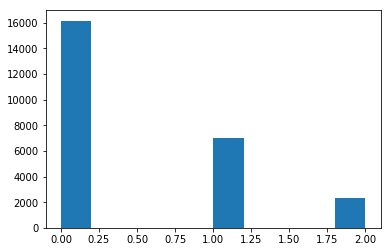

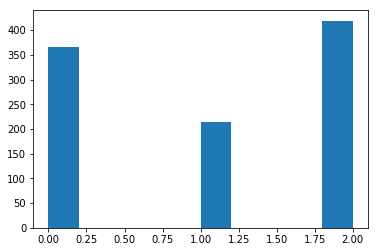

In [10]:
plt.hist(dataset_targets)
#plt.hist(targets_trn)
#plt.hist(targets_tst)

plt.figure()
plt.hist(preds_tst)

np.mean(targets_tst==2)

In [11]:
np.sum(targets == 3)

0